
# Alternative Solvers (e.g. Scipy, Petsc)
Here we look at different ways of solving PDEs using external
packages.
Different linear algebra backends can be accessed by changing setting the
`storage` parameter during construction of the discrete space. All
discrete functions and operators/schemes based on this space will then
use this backend. Available backends are `numpy,istl,petsc`. The default is
`numpy` which uses simple data structures and linear solvers implemented in
the `dune-fem` package - these backends were discussed
[in the previously section](solversInternal_nb.ipynb).

As discussed there, a degrees of freedom
vector (dof vector) can be retrieved from a discrete function over the
`numpy` space by using the `as_numpy` method. Similar attributes are available
for the other storages, i.e., `as_istl,as_petsc`. These attributes are
also available to retrieve the underlying matrix structures of linear
operators. We will show now how to use this to use `scipy` or `petsc4py`
to solve the (non) linear systems.

We start with the same setup as used [in the previously section](solversInternal_nb.ipynb):

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange
from dune.fem import integrate
from ufl import TestFunction, TrialFunction, SpatialCoordinate, FacetNormal, \
                dx, ds, div, grad, dot, inner, exp, sin, conditional

gridView = leafGridView([0, 0], [1, 1], [24, 24])
space = lagrange(gridView, order=2)
u_h = space.interpolate(0, name='u_h')

x,u,v,n = ( SpatialCoordinate(space), TrialFunction(space), TestFunction(space), FacetNormal(space) )
exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

a  = ( inner(grad(u),grad(v)) + (1+u**2)*u*v ) * dx
bf = (-div(grad(exact)) + (1+exact**2)*exact) * v * dx
bg = dot(grad(exact),n)*v*ds

# simple function to show the result of a simulation
def printResult(method,error,info):
    print(method,"L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
                 *[ np.sqrt(e) for e in integrate([error**2,inner(grad(error),grad(error))]) ]),
          "\n\t","solver info=",info,flush=True)

We will use the `galerkin` operator from `dune.fem.operator` instead of the
`scheme` used so far, since we do not need the `solve` method since we
want to use external solvers in this section:

In [2]:
from dune.fem.operator import galerkin
from dune.ufl import DirichletBC
operator = galerkin([a - (bf+bg), DirichletBC(space,exact,2)])

## Accessing underlying data structures

The most important step is accessing the data structures setup on the C++
side in Python. In this case we would like to use the underlying dof vector from
a discrete function as numpy arrays and system matrices assembled by the
schemes and operators as scipy sparse matrices.

In the [introduction](dune-fempy_nb.ipynb) we already discussed the
`as_numpy` attribute which allows access to the degrees of freedom as
numpy array based on the `python buffer protocol`.
So no data is copied and changes to the dofs made on the Python side are
automatically carried over to the C++ side.

We setup `u_h` to be zero but can initialize the dof vector with a random
values directly changing `u_h` itself:

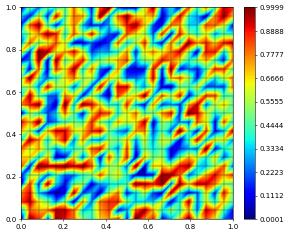

In [3]:
u_h.as_numpy[:] = np.random.rand(space.size)
u_h.plot()

.. tip:: changes to the numpy array `u_h.as_numpy` carries over to the discrete
   function `u_h`, just remember to make changes using `vecu_h[:]` to change the actual
   memory buffer.

An instance of `dune.fem.operator` describing an operator `L`
provides a method `linear` which returns an object that
stores a sparse matrix structure. The object describes the operator
linearized around zero.
To linearize around a different value use the `jacobian` method on the
`operator` that linearized
the the operator `L` around a given grid function `ubar` and fills the
linear operator structure passed in as second argument. It is also
possible to pass ``assemble=False`` to the ``linear`` method to avoid an
the linearization around zero to reduce computational cost:

In [4]:
linOp = operator.linear()                  # linearized around 0
linOp = operator.linear(assemble=False)    # empty (non valid) linear operator
operator.jacobian(space.zero, linOp)       # linearized around zero

Here we linearize around zero. But that argument could be any grid
function. A second version of this method will return an addition
discrete function `rhs` which equals `-L[ubar]` such that `DL[ubar](u-ubar) - rhs` are the first
terms in the Taylor expansion of the operator `L`:

In [5]:
rhs = u_h.copy()
operator.jacobian(u_h, linOp, rhs)

One can now easily access the underlying sparse matrix by again using
`as_numpy` (and again the underlying data buffers are not copied):

<class 'scipy.sparse._csr.csr_matrix'>


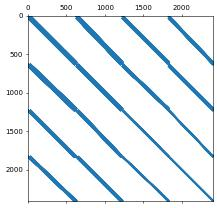

In [6]:
A = linOp.as_numpy
print(type(A),flush=True)
plt.spy(A, precision=1e-8, markersize=1)

## Defining discrete function with given external dof vector

As a last step we sometimes need to construct a discrete function based
on a given dof vector. Here a simple example where we use a `numpy`
random vector as dof vector for a discrete function:

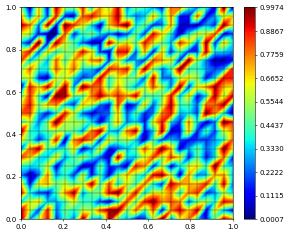

In [7]:
v_coeff = np.random.rand(space.size)
vh = space.function("random", dofVector=v_coeff)
vh.plot()

Again the dof vector is not copied so changing the `numpy` array will
directly change the discrete function

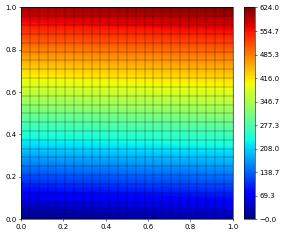

In [8]:
v_coeff[:] = range(space.size)
vh.plot()

Now we have all the ingredients to write a simple Newton solver to solve
our non-linear time dependent PDE.

.. index::
   pair: Solvers; Scipy

## Using Scipy
In our first example, we implement a simple Newton Krylov solver using a
`cg` solver from Scipy.

.. note::
   As pointed out the system matrix is no longer
   symmetric due to the handling of the Dirichlet constraints. For this
   reason we need to provide an initial guess to the `cg` solver with the
   degrees of freedom on the boundary set to be equal to the corresponding
   degrees of freedom in the right hand side vector. For this we use the
   `setConstraints` method on the solver.

iter 0 : 4.431052148382562


iter 1 : 0.04276612643235494


iter 2 : 0.002883781339264266


iter 3 : 2.2434900427670995e-05


iter 4 : 1.4130851244438762e-09


Scipy-1 L^2, H^1 error: 1.17626e-06, 1.83002e-04 
	 solver info= {'iterations': 4, 'linear_iterations': 856}


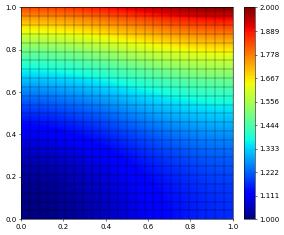

In [9]:
from scipy.sparse.linalg import cg
class Scheme1:
    def __init__(self, op):
        self.model = op.model
        self.jacobian = op.linear()
        self.op = op
        self.linIter = 0

    def callback(self,x):
        self.linIter += 1

    def solve(self, target):
        # create a copy of target for the residual
        res = target.copy(name="residual")
        initialGuess = target.copy(name="initial-guess")

        # extract numpy vectors from target and res
        sol_coeff = target.as_numpy
        res_coeff = res.as_numpy
        x0 = initialGuess.as_numpy

        n = 0
        while True:
            self.op(target, res)
            absF = np.sqrt( np.dot(res_coeff,res_coeff) )
            print(f"iter {n} : {absF}",flush=True)
            if absF < 1e-6:
                break
            self.op.jacobian(target,self.jacobian)
            self.op.setConstraints(res,initialGuess)
            dh_coeff = cg(self.jacobian.as_numpy, res_coeff, x0,
                          callback=self.callback )
            sol_coeff -= dh_coeff[0]
            n += 1
        return {"iterations":n, "linear_iterations":self.linIter}

scheme1_cls = Scheme1(operator)
u_h.interpolate(2)
info = scheme1_cls.solve(target=u_h)
printResult("Scipy-1",u_h-exact,info)
u_h.plot()

We can also use a non linear solver from the Scipy package - together
for example with an incomplete LU factorization for the Jacobian.

.. note::
   since we are using a LU type method here (i.e. a direct solver) we do
   not need to worry about the constraints as with the `cg` method
   previously.

Newton residual: 0.0018287557646036968
Newton residual: 8.313374500986622e-06
Newton residual: 5.033660790123935e-10
Newton residual: 1.8226133191208854e-17


Scipy-2 L^2, H^1 error: 1.17626e-06, 1.83002e-04 
	 solver info= {'iterations': 4, 'linear_iterations': 16}


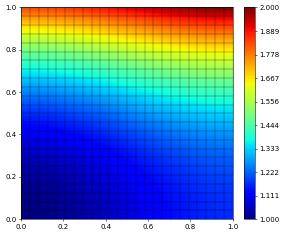

In [10]:
from scipy.optimize import newton_krylov
from scipy.sparse.linalg import LinearOperator,spilu

class Scheme2:
    def __init__(self, op):
        self.op = op
        self.model = op.model
        self.linIter = 0

    def linCallback(self,x):
        self.linIter += 1
    def linSolver(self,*args,**kwargs):
        return cg(*args,**kwargs,callback=self.linCallback)

    # non linear function
    def f(self, x_coeff):
        # the following converts a given numpy array
        # into a discrete function over the given space
        x = self.op.domainSpace.function("tmp", dofVector=x_coeff)
        self.op(x, self.res)
        return self.res.as_numpy
    def callback(self,x,fx):
        print("Newton residual:",fx.dot(fx))

    # class for the derivative DS of S
    class Df(LinearOperator):
        def __init__(self, op, x_coeff):
            self.op = op
            self.shape = (x_coeff.shape[0], x_coeff.shape[0])
            self.dtype = x_coeff.dtype
            x = self.op.domainSpace.function("tmp", dofVector=x_coeff)
            self.jacobian = self.op.linear()
            self.n = -1
            self.update(x_coeff,None)
        # reassemble the matrix DF(u) given a DoF vector for u
        def update(self, x_coeff, f):
            x = self.op.domainSpace.function("tmp", dofVector=x_coeff)
            self.op.jacobian(x, self.jacobian)
            self.invJac = spilu(self.jacobian.as_numpy.tocsc())
            self.n += 1
        # compute DS(u)^{-1}x for a given DoF vector x
        def _matvec(self, x_coeff):
            return self.invJac.solve(x_coeff)


    def solve(self, target):
        self.res = target.copy(name="residual")
        sol_coeff = target.as_numpy
        M = self.Df(self.op,sol_coeff)
        # call the newton krylov solver from scipy
        sol_coeff[:] = newton_krylov(self.f, sol_coeff,
                    f_tol=1e-6, callback=self.callback,
                    method=self.linSolver, inner_M=M)
        return {"iterations":M.n, "linear_iterations":self.linIter}

scheme2_cls = Scheme2(operator)
u_h.interpolate(2)
info = scheme2_cls.solve(target=u_h)
printResult("Scipy-2",u_h-exact,info)
u_h.plot()

.. index::
   pair: Solvers; Umfpack (scikit)

## Using scikit-umfpack
While `umfpack` can be used as a direct [internal solver](solversInternal_nb.ipynb)
a more fine grained usage is sometimes available through the Python
binding for `umfpack` available through the `scikit` package.
which needs to be installed for the following to run:

In [11]:
try:
    import scikits.umfpack as um
except ModuleNotFoundError:
    print("can not import scikits.umfpacl ")
    um = None

We will demonstrate the usage by solving our non-linear problem with a
hand written Newton method assuming that the symbolic
decomposition of the system matrix can be reused in each step:

if um:
    class Scheme3:
        def __init__(self, op):
            self.model = op.model
            self.jacobian = op.linear()
            self.op = op
            self.umfpack = um.UmfpackContext() # Use default 'di' family of UMFPACK routines.
            self.umfpack.symbolic( self.jacobian.as_numpy )

        def solve(self, target):
            # create a copy of target for the residual
            res = target.copy(name="residual")

            # extract numpy vectors from target and res
            sol_coeff = target.as_numpy
            res_coeff = res.as_numpy

            n = 0
            while True:
                self.op(target, res)
                absF = np.sqrt( np.dot(res_coeff,res_coeff) )
                print(f"iter {n} : {absF}",flush=True)
                if absF < 1e-6:
                    break
                self.op.jacobian(target,self.jacobian)
                A = self.jacobian.as_numpy[:]
                self.umfpack.numeric( A )
                sol_coeff -= self.umfpack( um.UMFPACK_A, A, res_coeff, autoTranspose = True )
                n += 1
            return {"iterations":n, "linear_iterations":-1}

    scheme1_cls = Scheme3(operator)
    u_h.interpolate(2)
    info = scheme1_cls.solve(target=u_h)
    printResult("scikit-umfpack",u_h-exact,info)
    u_h.plot()

.. index::
   pair: Solvers; Petsc4Py

## Using PETSc4Py
The following requires that a PETSc installation was found during the
configuration of ``dune``. Furthermore the Python package ``petsc4py`
is required:

In [12]:
from dune.common.checkconfiguration import assertCMakeHave, ConfigurationError
try:
    assertCMakeHave("HAVE_PETSC")
    petsc = True
except ConfigurationError:
    print("Dune not configured with petsc - skipping example")
    petsc = False
try:
    import sys
    import petsc4py
    petsc4py.init(sys.argv)
    from petsc4py import PETSc
except ModuleNotFoundError:
    print("petsc4py module not found -- skipping example")
    petsc4py = None

petsc4py module not found -- skipping example


To use `petsc4py` we need to which to a storage based on the PETSc package
using the ``storage`` argument to the space constructor.

Implementing a Newton Krylov solver using the binding provided by
`petsc4py` is now straightforward - we again use incomplete LU as
preconditioner:

In [13]:
if petsc4py is not None and petsc:
    petsc_options = PETSc.Options()
    spacePetsc = lagrange(gridView, order=2, storage='petsc')
    u_h = spacePetsc.interpolate(2, name='u_h')  # start with solution at top boundary
    opPetsc = galerkin([a==bf+bg,DirichletBC(spacePetsc,exact,2)],
                       domainSpace=spacePetsc,rangeSpace=spacePetsc)

    class Scheme4:
        def __init__(self, op):
            self.op = op
            self.jacobian = op.linear()
            self.ksp = PETSc.KSP()
            self.ksp.create(PETSc.COMM_WORLD)
            # use conjugate gradients method
            self.ksp.setType("cg")
            # use sor preconditioner
            # self.ksp.getPC().setType("sor")
            # or ILU(1)
            self.ksp.getPC().setType("ilu")
            petsc_options['pc_factor_levels'] = 1
            self.ksp.setOperators(self.jacobian.as_petsc)
            self.ksp.setInitialGuessNonzero(True)
            self.ksp.setFromOptions()
        def solve(self, target):
            res = target.copy(name="residual")
            dh = target.copy(name="direction")
            sol_coeff = target.as_petsc
            dh_coeff = dh.as_petsc
            res_coeff = res.as_petsc
            n = 0
            numIter = 0
            while True:
                self.op(target, res)
                absF = np.sqrt( np.dot(res_coeff,res_coeff) )
                if absF < 1e-6:
                    break
                dh.clear()
                self.op.jacobian(target,self.jacobian)
                self.op.setConstraints(res,dh) # petsc does not seem to need this...
                self.ksp.setUp()
                self.ksp.solve(res_coeff, dh_coeff)
                numIter += self.ksp.getIterationNumber()
                sol_coeff -= dh_coeff
                n += 1
            return {"iterations":n, "linear_iterations":numIter}

    u_h.interpolate(2)
    scheme3_cls = Scheme4(opPetsc)
    info = scheme3_cls.solve(target=u_h)
    printResult("PETSc4py 1",u_h-exact,info)
    u_h.plot()

Here is another example now using the petsc4py bindings for the non
linear KSP solvers from PETSc. This time we use a algebraic multigrid
preconditioner:

In [14]:
if petsc4py is not None and petsc is not None:
    class Scheme5:
        def __init__(self, op):
            self.op = op
            self.res = op.rangeSpace.interpolate(0,name="residual")
            self.jacobian = op.linear()
            self.snes = PETSc.SNES().create()
            self.snes.setFunction(self.f, self.res.as_petsc.duplicate())
            self.snes.setUseMF(False)
            self.snes.setJacobian(self.Df, self.jacobian.as_petsc, self.jacobian.as_petsc)
            self.snes.setTolerances(atol=1e-6)
            self.snes.getKSP().setType("cg")
            self.snes.getKSP().getPC().setType("hypre")
            petsc_options['pc_hypre_type'] = 'boomeramg'
            self.snes.setFromOptions()

        def f(self, snes, x, f):
            # setup discrete function using the provide petsc vectors
            inDF = self.op.domainSpace.function("tmp",dofVector=x)
            outDF = self.op.rangeSpace.function("tmp",dofVector=f)
            self.op(inDF,outDF)

        def Df(self, snes, x, m, b):
            inDF = self.op.domainSpace.function("tmp",dofVector=x)
            self.op.jacobian(inDF, self.jacobian)
            return PETSc.Mat.Structure.SAME_NONZERO_PATTERN

        def solve(self, target):
            sol_coeff = target.as_petsc
            self.res.clear()
            self.snes.solve(self.res.as_petsc, sol_coeff)
            return {"iterations":self.snes.getIterationNumber(),
                    "linear_iterations":self.snes.getLinearSolveIterations()}

    scheme4_cls = Scheme5(opPetsc)
    u_h.interpolate(2)
    info = scheme4_cls.solve(target=u_h)
    printResult("PETSc4py 2",u_h-exact,info)
    u_h.plot()